The objective of this notebook is to show how to use the isStationary method of MovingObject instances to identify completely stationary objects, and extract when objects are moving for some time interval, as can be detected using tracking by detection, e.g., the dltrack.py script.

For this notebook, we use the GH023678-dl.sqlite database of trajectories. 

In [1]:
from trafficintelligence import utils, storage
from trafficintelligence.moving import TimeInterval
import matplotlib.pyplot as plt

In [2]:
# parameters
speedThreshold = 0.01 # m/frame = 0.3 m/s 
distanceThreshold = 1. # m
minObjectDuration = 30

In [3]:
objects = storage.loadTrajectoriesFromSqlite('../data/GH023678-dl.sqlite', 'object')
# we apply the parameters only to motorized users
motorized = [o for o in objects if o.getUserType() in [1,5,6]]

The code below assumes that if the object is stationary for only an interval, and objects before and after are long enough, then if object moves only at the beginning or at the end, it is interpreted as respectively the car stopping to park, or the parked car leaving. If moving at the beginning and end, it is viewed as a car stopping, eg at the stop sign, then starting again. threshold for normal stopped time in traffic could be used. 

In [4]:
stationaryObjects = []
movingObjects = []
for o in motorized:
    stationary, instants = o.isStationary(speedThreshold, distanceThreshold)
    if stationary:
        if instants is None:
            stationaryObjects.append(o)
        else:
            if instants[0]-1-o.getFirstInstant() >= minObjectDuration:
                moving1 = True # object stopping
            else:
                moving1 = False
            if o.getLastInstant()-instants[1]-1 >= minObjectDuration:
                moving2 = True # object starting
            else:
                moving2 = False
            if moving1 and not moving2:
                tmp = o.splitOverTime([instants[0]], minObjectDuration)
                movingObjects.append(tmp[0])
                if len(tmp)>1:
                    stationaryObjects.append(tmp[1])
            elif not moving1 and moving2:
                tmp = o.splitOverTime([instants[1]], minObjectDuration)
                stationaryObjects.append(tmp[0])
                if len(tmp)>1:
                    movingObjects.append(tmp[1])
            elif moving1 and moving2: # moving beginning and end
                movingObjects.append(o)
            else:
                stationaryObjects.append(o)
    else:
        movingObjects.append(o)
print(len(motorized), len(stationaryObjects), len(movingObjects))
# quality control rapid accelerationtants

26 12 15


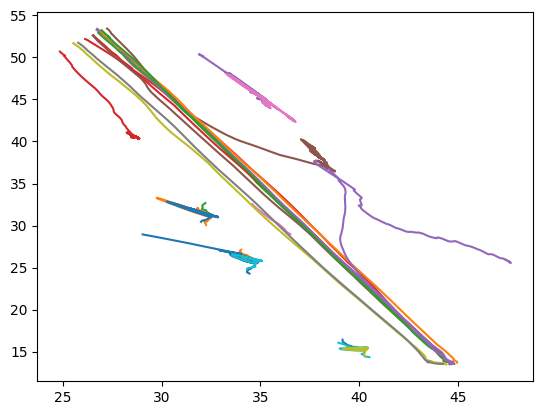

In [5]:
for o in motorized:
    o.plot()
#plt.axis("equal")
plt.figure()
stationaryObjects[0].plot('r', label='stationary')
for o in stationaryObjects[1:]:
    o.plot('r')
movingObjects[0].plot('b', label='moving')
for o in movingObjects[1:]:
    o.plot('b')
plt.legend()

The code is only applied to cars, in particular to detect parking. Interpretation is difficult nonetheless. Example is object 191, that includes a tracking error of a car parking, then the driver leaving the car, but the trajectories of the car and the person get mixed. 